In [ ]:
import numpy as np
import scipy.stats
import random
import matplotlib.pyplot as plt
import sys
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score
np.set_printoptions(suppress=True)

### Helper Functions

In [ ]:

def gen_class_samples(num_samples, priors, label_ids):
    num_labels = len(label_ids)
    class_samples = np.array([0]*num_labels)
    for num_sample in range(num_samples):
        pr = random.uniform(0.0, 1.0)
        if pr <= priors[0]:
            class_samples[0] += 1
        elif pr <= priors[0] + priors[1]:
            class_samples[1] += 1
        elif pr <= priors[0] + priors[1] + priors[2]:
            class_samples[2] += 1
        else:
            class_samples[3] +=1
    
    return class_samples

def generate_data_pxgl(priors, means, covs, num_samples, label_ids):
    class_samples = gen_class_samples(num_samples, priors, label_ids)

    #generate class data
    pxgls = np.array([], dtype=float).reshape(2,0)
    labels = []
    for label_id in label_ids:
        num_cls_samples = class_samples[label_id]
        mean = means[label_id]
        cov = covs[label_id]
        pxgl = np.random.multivariate_normal(mean, cov, num_cls_samples).T
        pxgls = np.concatenate((pxgls, pxgl), axis=1)
        class_label = [label_id]*num_cls_samples
        labels += class_label

    labels = np.array(labels).reshape((1, -1))
    data = np.concatenate((pxgls, labels), axis=0)

    return data,class_samples

def generate_data_pxgl_samples(samples_type, priors, means, covs, label_ids):
    for i, key in enumerate(samples_type.keys()):
        sample_type = samples_type[key]
        num_samples = int(sample_type[0][0])
        data_wt_labels, cls_samples = generate_data_pxgl(priors, means, covs, num_samples,label_ids)
        sample_type[1] = cls_samples
        sample_type[2] = data_wt_labels
        label_names = ["True label distribution of " + str(num_samples) + " samples using four components", "x", "y"]
        plot_dist(data_wt_labels, label_names, label_ids)  
    
    return samples_type

def plot_dist(data, label_names, label_ids):
    tname, xname, yname = label_names
    print('***** plots *****')
    samples = split_data(data, label_ids)
    colors = ['red', 'blue', 'green', 'brown']
    for label_id, sample in enumerate(samples):
        plt.scatter(sample[0, :], sample[1, :], s=5, color = colors[label_id], label = 'class ' + str(label_id), marker='*')

    plt.title(tname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.legend()
    plt.show()

def split_data(data_wt_labels, label_ids):
    samples = []
    for label_id in label_ids:
        class_ids = np.where(data_wt_labels[-1,:]==label_id)[0]
        cls_samples = data_wt_labels[:,class_ids]
        samples.append(cls_samples)
    
    return samples

def plot_hist(num_gmm_freq, num_samples, num_time):
    #print('num_gmm_freq: ',num_gmm_freq)
    n_bins = len(num_gmm_lst)
    fig, ax = plt.subplots(tight_layout=True)
    ax.set_xlim([1, 6])
    ax.hist(num_gmm_freq, bins=n_bins)
    plt.title('Frequency of model order across 35 experiments for ' + str(num_samples) + 'samples')
    plt.xlabel('GMM model orders')
    plt.ylabel('Frequency of GMM model order')
    plt.show()

def MOS(sample_type, kfold, num_repeat):
    num_samples = sample_type[0][0]
    num_gmm_freq = np.zeros((num_repeat,), dtype=int)
    for num_time in range(num_repeat):
        data_wt_labels, cls_samples = generate_data_pxgl(priors, means, covs, num_samples,
        label_ids)
        data_wt_labels = data_wt_labels[:, np.random.permutation(data_wt_labels.shape[1])]

        data = data_wt_labels[:2,:].T #(N, 2)
        labels = data_wt_labels[2,:].T
        gmm_mean = np.zeros((len(num_gmm_lst),), dtype=float)
        gmm_std = np.zeros((len(num_gmm_lst),), dtype=float)
        for num_gmm in num_gmm_lst:
            GMM = GaussianMixture(num_gmm, covariance_type='full', random_state=0)
            scores = cross_val_score(GMM, data, labels, cv=kfold)
            mean_scores = np.mean(scores)
            std_scores = np.std(scores)
            gmm_mean[num_gmm-1] = mean_scores
            gmm_std[num_gmm-1] = std_scores
            #print('num_samples: ', num_samples, ' num_gmm: ', num_gmm,' mean_scores: ',np.round(mean_scores, 4), ' std_scores: ', np.round(std_scores, 4))
        
        desired_num_gmm = np.argmin(abs(gmm_mean)) + 1
        #print('desired_num_gmm ',desired_num_gmm)
        num_gmm_freq[num_time] = desired_num_gmm   

    plot_hist(num_gmm_freq, num_samples, num_time+1)


A 2-dimensional real-valued random vector was generated using a Gaussian
Mixture Model (GMM) with 4 components. Each of these components have different mean vectors, different covariance matrices and different prior.

$m_1 = \begin{bmatrix}35 \\ 0\end{bmatrix}$
$m_2 = \begin{bmatrix}35 \\ 52.5\end{bmatrix}$
$m_3 = \begin{bmatrix}0 \\ 0\end{bmatrix}$
$m_4 = \begin{bmatrix}0 \\ 52.5\end{bmatrix}$


$C_1 = \begin{bmatrix}10 & 20 \\ 0 & 40\end{bmatrix}$
$C_2 = \begin{bmatrix}20 & 0 \\ 40 & 5\end{bmatrix}$
$C_3 = \begin{bmatrix}20 & 30 \\ 0 & 10\end{bmatrix}$
$C_4 = \begin{bmatrix}5 & 0 \\ 10 & 20\end{bmatrix}$

$P(L=0) = 0.1$
$P(L=1) = 0.2$
$P(L=2) = 0.3$
$P(L=3) = 0.4$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7

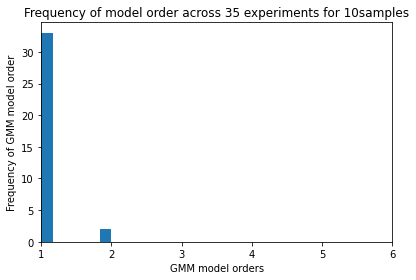

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7

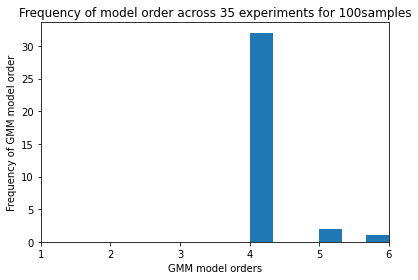

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7

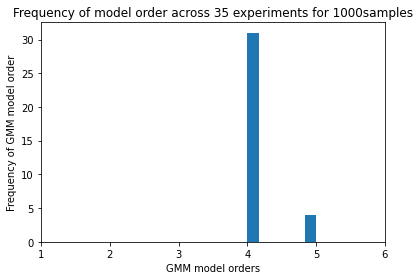

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.7

In [ ]:

if __name__ == "__main__":
    dim = 2
    label_ids = [0, 1, 2, 3]
    num_labels = len(label_ids)
    priors = [0.1, 0.2, 0.3, 0.4]
    kfold = 10
    num_repeat = 35
    num_gmm_lst = [1, 2, 3, 4, 5, 6]

    samples_type = {
                    'D10': [[10], [], []],\
                    'D100': [[100], [], []],\
                    'D1k': [[1000], [], []],\
                    'D10k': [[10000], [], []],
                }

    m0 = np.array([35, 0])
    m1 = np.array([35, 52.5])
    m2 = np.array([0, 0])
    m3 = np.array([0, 52.5])
    C0 = np.array([[10, 20], [0, 40]])
    C1 = np.array([[20, 0], [40, 5]])
    C2 = np.array([[20, 30], [0, 10]])
    C3 = np.array([[5, 0], [10, 20]])
    means = [m0, m1, m2, m3]
    covs = [C0, C1, C2, C3]
    

    #Model Order Selection
    for i, key in enumerate(list(samples_type.keys())):
        MOS(samples_type[key], kfold, num_repeat)

10-fold cross-validation to find the best number of GMM components for each of the above-mentioned datasets. The number of GMM components used for model selection were 1, 2, 3, 4, 5, and 6.

The iterative numerical optimization method used here is Expectation-Maximization(EM) algorithm. This algorithm maximizes the expected value of the log likelihood function of θ as shown below.

| Dataset | 1    | 2   | 3 | 4    | 5    | 6    |
|---------|------|-----|---|------|------|------|
| T10     | 0.91 | 0.9 | 0 | 0    | 0    | 0.0  |
| T100    | 0    | 0   | 0 | 0.94 | 0.06 | 0.0  |
| T1K     | 0    | 0   | 0 | 0.54 | 0.34 | 0.11 |
| T10K    | 0    | 0   | 0 | 0.85 | 0.15 | 0.0  |

A very general trend that was found that higher number of gaussian component model was selected when more data was available
